In [17]:
import os

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [247]:
# model_name = "EleutherAI/pythia-160m"
model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [292]:
# text = " ".join([str(i) for i in range(500)])
# text = "Hey, how are you today?"
# text = "one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twenty-one, twenty-two, twenty-three, twenty-four, twenty-five, twenty-six, twenty-seven, twenty-eight, twenty-nine, thirty, thirty-one, thirty-two, thirty-three, thirty-four, thirty-five, thirty-six, thirty-seven, thirty-eight, thirty-nine, forty, forty-one, forty-two, forty-three, forty-four, forty-five, forty-six, forty-seven, forty-eight, forty-nine, fifty, fifty-one, fifty-two, fifty-three, fifty-four, fifty-five, fifty-six, fifty-seven, fifty-eight, fifty-nine, sixty, sixty-one, sixty-two, sixty-three, sixty-four, sixty-five, sixty-six, sixty-seven, sixty-eight, sixty-nine, seventy, seventy-one, seventy-two, seventy-three, seventy-four, seventy-five, seventy-six, seventy-seven, seventy-eight, seventy-nine, eighty, eighty-one, eighty-two, eighty-three, eighty-four, eighty-five, eighty-six, eighty-seven, eighty-eight, eighty-nine, ninety, ninety-one, ninety-two, ninety-three, ninety-four, ninety-five, ninety-six, ninety-seven, ninety-eight, ninety-nine, one hundred."
# text = "".join(text.split(','))
text = "sjdhfklajdnf asdfkjnaslkjdg a fsdjkfnajsdbfas fjasbdfja sd fljahbvdfla sdflajhlds f;asdf;a sd;fajs d;ia dspifhas;dhfa;sidufhakjsdfnakljsdbflajksdbg ladhfa sdlf asdfgalisdhfglaj ksdbf ljsgdflja sdbf lajksdhlfkjahs dflkjadbf ajkdsfjkas."

# text = '''
#     Twinkle, twinkle, little star,
# How I wonder what you are!
# Up above the world so high,
# Like a diamond in the sky.

# When the blazing sun is gone,
# When he nothing shines upon,
# Then you show your little light,
# Twinkle, twinkle, all the night.
# '''

tokens = tokenizer(text, return_tensors='pt')['input_ids']
max_tokens = tokens.shape[1]

In [293]:
tokens.shape

torch.Size([1, 128])

In [294]:
all_hidden_states = torch.empty((model.config.num_hidden_layers, max_tokens - 1, model.config.hidden_size))

# Iterate through each token up to k (excluding the last since there's no next token)
for i in range(max_tokens - 1):
    # Generate output and hidden states up to the current token
    with torch.no_grad():
        outputs = model(tokens[:, :i+1], output_hidden_states=True)
    
    # Extract hidden states
    hidden_states = outputs.hidden_states  # Tuple of hidden states per layer

    # Store the hidden states of the last token across all layers
    for layer in range(model.config.num_hidden_layers):
        all_hidden_states[layer, i, :] = hidden_states[layer][:, -1, :]

# Reshape tensor to match the requested shape: [num_layers, num_tokens-1, hidden_dim]
all_hidden_states = all_hidden_states[:, :max_tokens - 1, :]

In [295]:
i

126

In [296]:
hidden_states[0].shape

torch.Size([1, 127, 768])

In [297]:
all_hidden_states.shape

torch.Size([12, 127, 768])

In [298]:
token_embeddings = model.tran.embed_in(tokens).detach()

AttributeError: 'GPT2LMHeadModel' object has no attribute 'tran'

In [299]:
token_embeddings.shape

torch.Size([1, 246, 768])

In [300]:
outputs = all_hidden_states

In [301]:
outputs.keys()

AttributeError: 'Tensor' object has no attribute 'keys'

In [302]:
import umap
import matplotlib.pyplot as plt

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


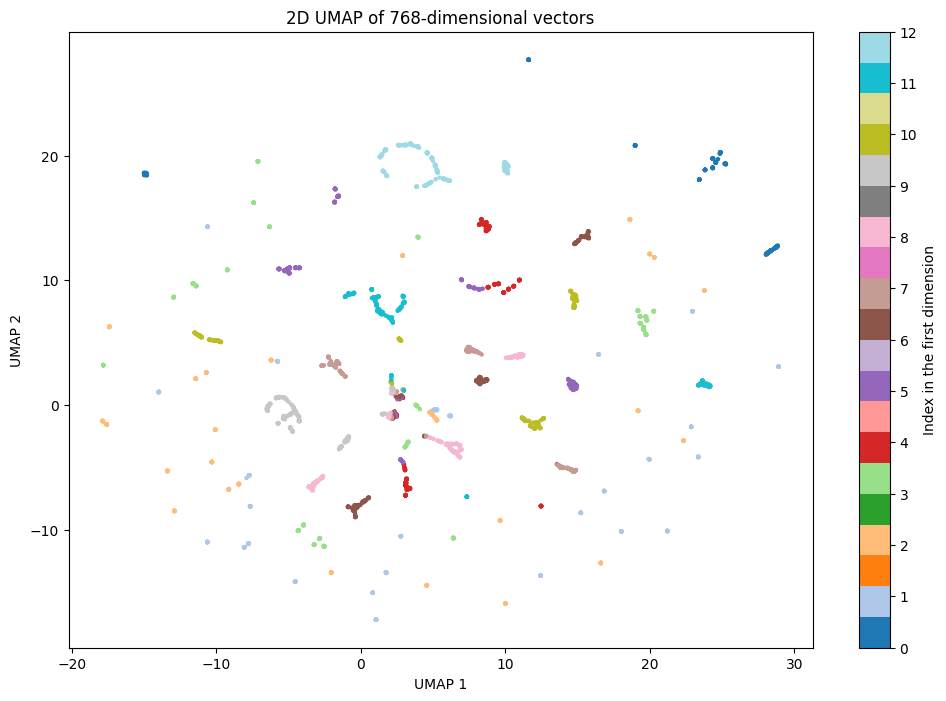

In [309]:
data = outputs_hiddens.detach().reshape(-1, 768)

# Compute the UMAP embedding
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
embedding = reducer.fit_transform(data)

# Generate labels for coloring
labels = torch.arange(13).repeat_interleave(outputs_hiddens.shape[1]).numpy()

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab20', s=5)
plt.colorbar(scatter, ticks=range(13), label='Index in the first dimension')
plt.title('2D UMAP of 768-dimensional vectors')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisatio

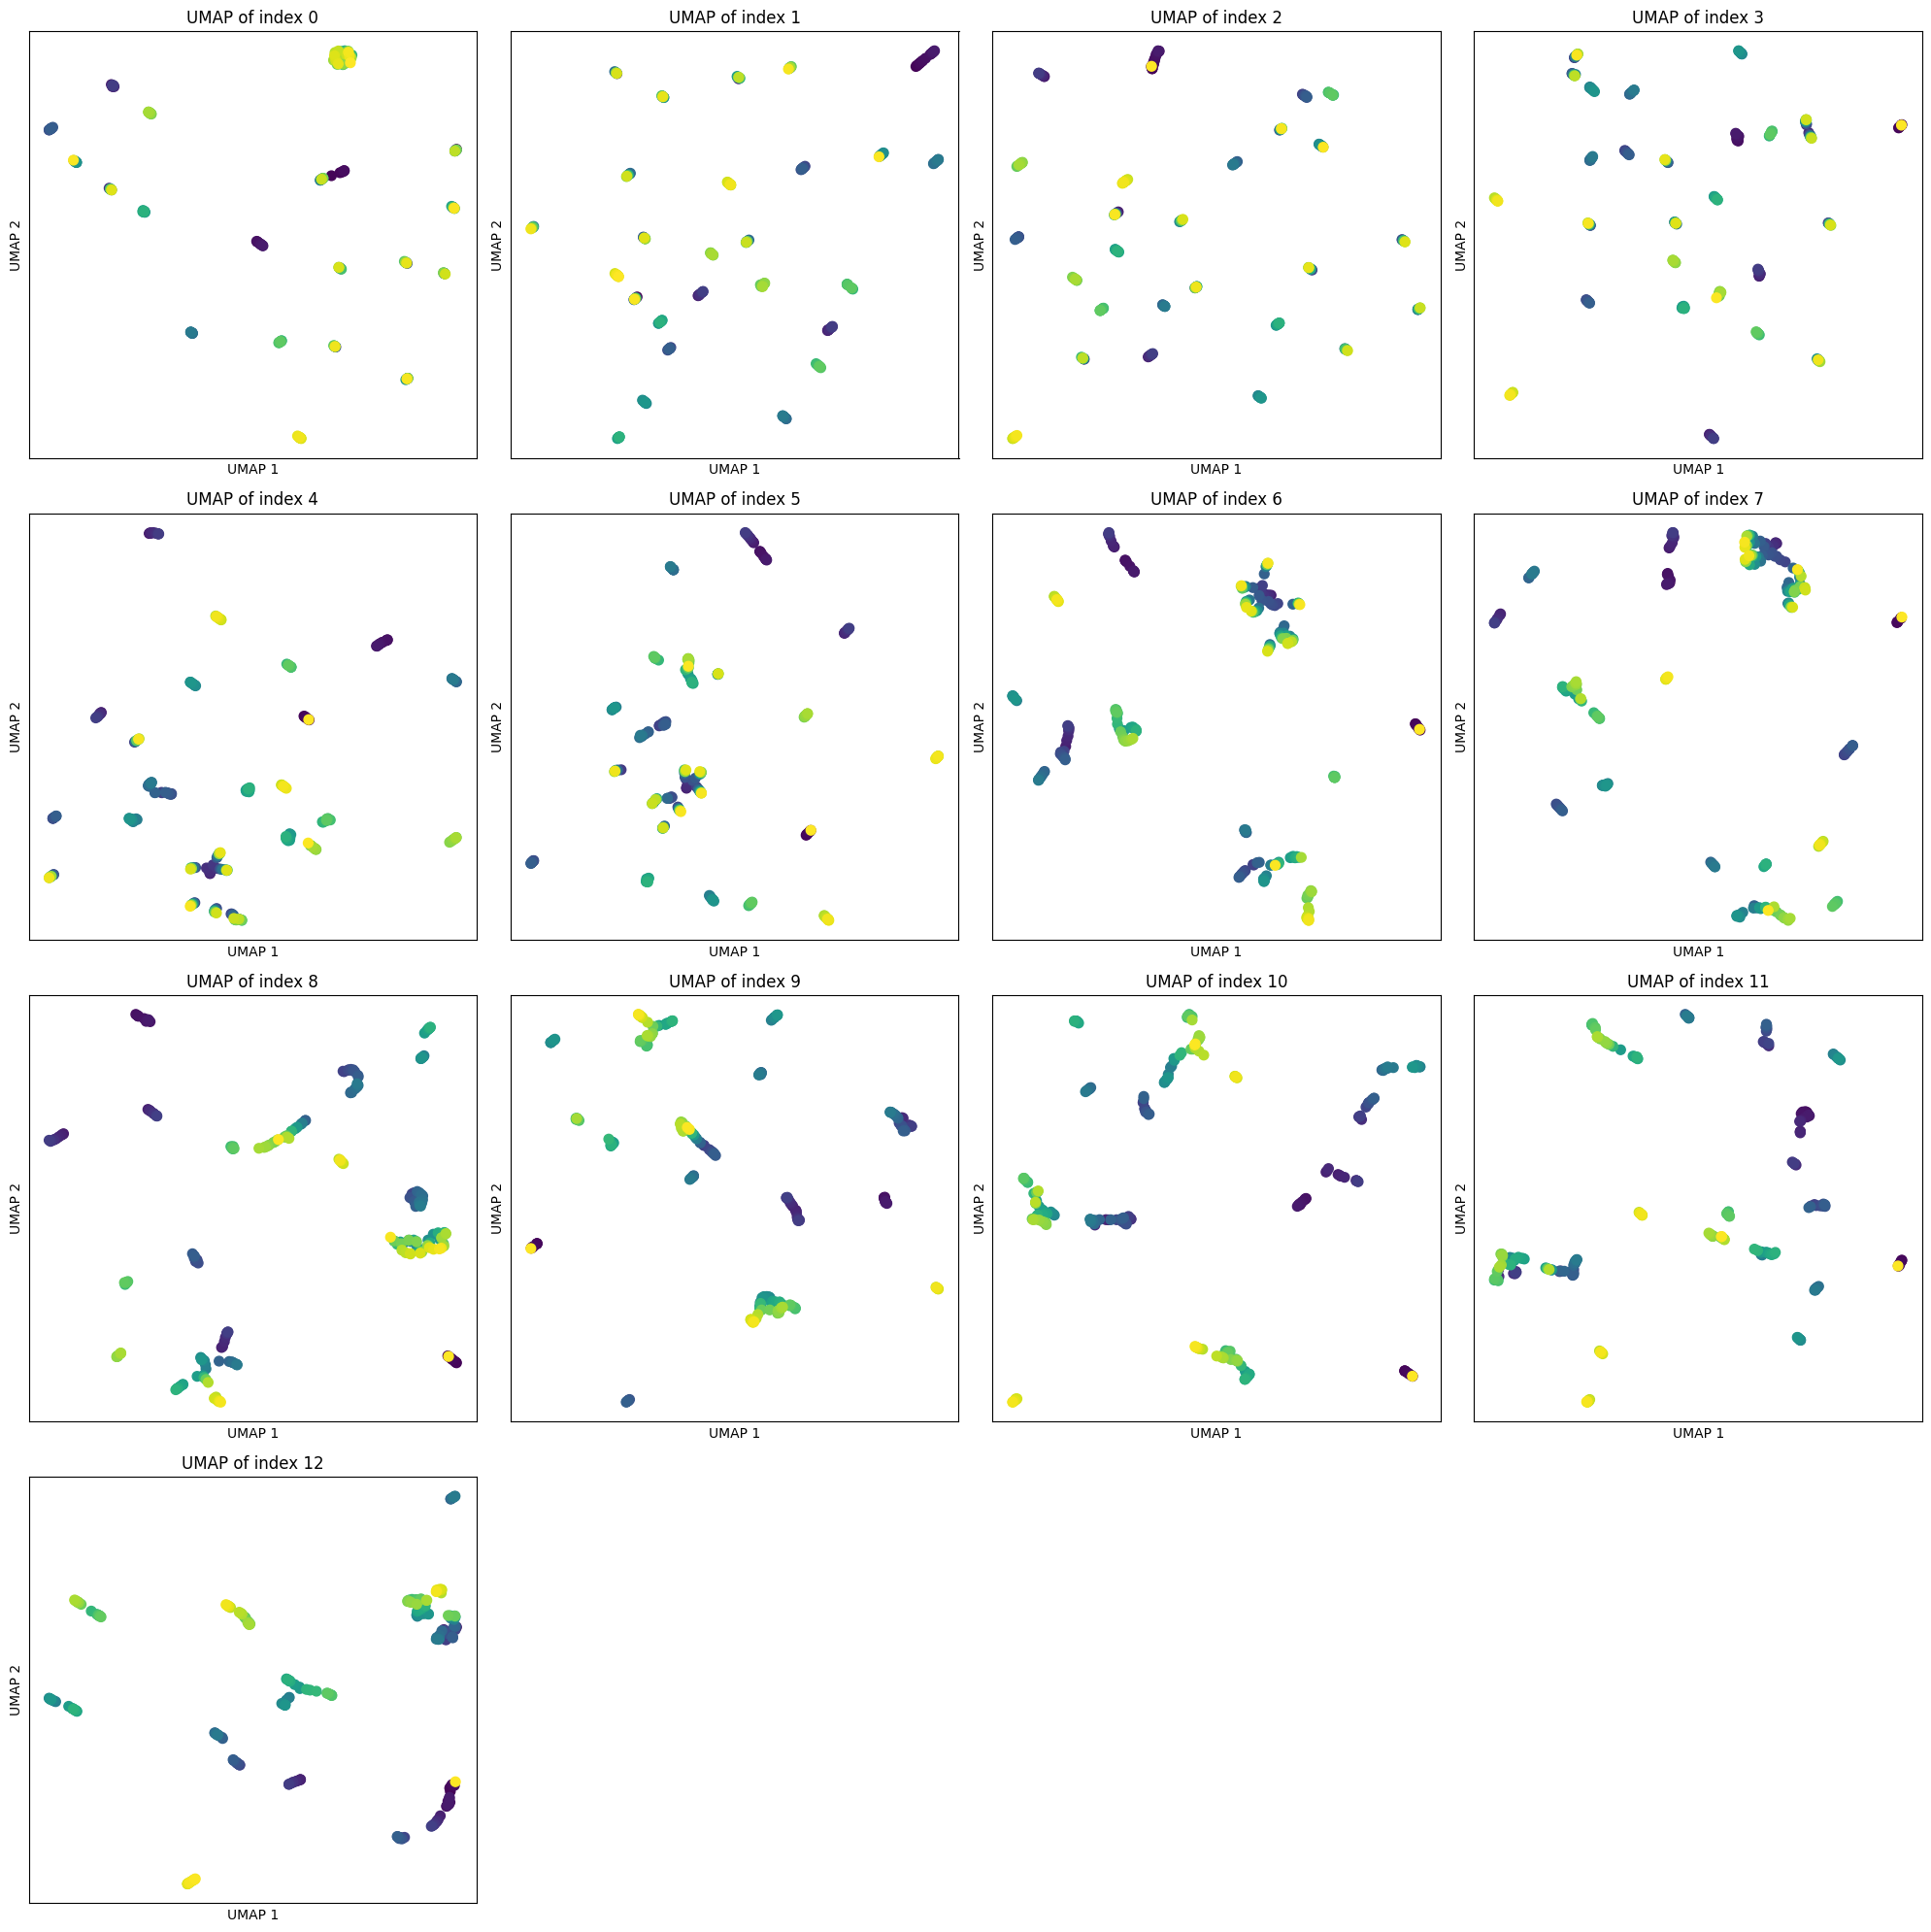

In [304]:
# Prepare the UMAP reducer
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, random_state=42)

# Create a figure with 13 subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # Adjusted for a 4x4 grid; one will be empty
# tensor = torch.concat([token_embeddings, outputs_hiddens.detach()], axis=0)
tensor = outputs_hiddens.detach()
for i in range(13):
    # Select the slice for the current index in the first dimension
    data_slice = tensor[i].numpy()  # Shape [12, 768]
    
    reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, random_state=42)
    # Compute the UMAP embedding for this slice
    embedding = reducer.fit_transform(data_slice)
    
    # Get the corresponding subplot
    ax = axes[i // 4, i % 4]
    
    # Plotting
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=range(outputs_hiddens.shape[1]), cmap='viridis', s=50)
    ax.set_title(f'UMAP of index {i}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

# Hide the last subplot (if any) in case of an incomplete grid
for j in range(i + 1, 16):
    axes[j // 4, j % 4].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

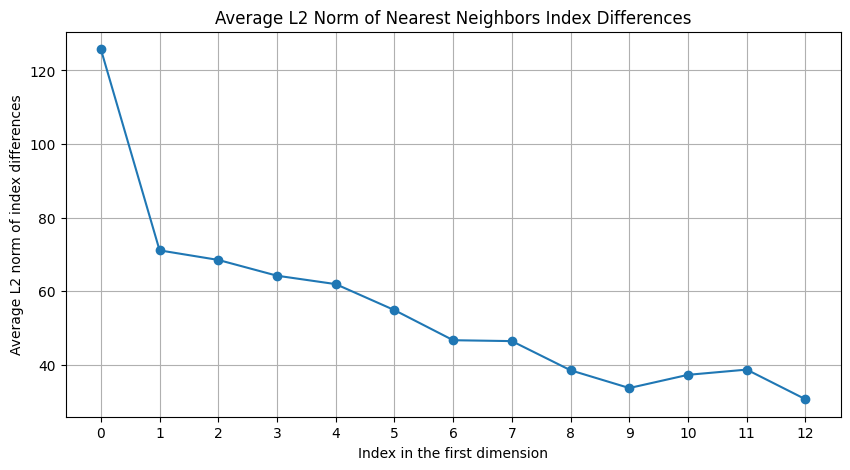

In [307]:
import torch
import matplotlib.pyplot as plt

# Generate a random tensor of shape (13, 100, 768)
# tensor = torch.concat([token_embeddings, outputs_hiddens.detach()], axis=0)
tensor = outputs_hiddens.detach()
num_layers = tensor.shape[0]

# Placeholder for average norms for each first index
average_norms = []

# Iterate through each group in the first dimension
for i in range(tensor.shape[0]):
    data_group = tensor[i]  # Shape (100, 768)
    
    # Compute pairwise distances between vectors in the group
    dist_matrix = torch.cdist(data_group, data_group, p=2)
    
    # We set the diagonal to a very high value to avoid selecting the point itself as its neighbor
    dist_matrix.fill_diagonal_(1e5)
    
    # Get the indices of the 5 nearest neighbors for each vector
    _, indices = torch.topk(dist_matrix, k=5, largest=False)
    
    # Calculate the difference in the 2nd-dimensional indices of the neighbors
    indices_diff = indices - torch.arange(tensor.shape[1])[:, None]
    
    # Compute the L2 norm of the differences
    norms = torch.norm(indices_diff.float(), dim=1)
    
    # Take the average of the norms and store
    average_norms.append(norms.mean().item())

# Plotting the average norms
plt.figure(figsize=(10, 5))
plt.plot(range(0, num_layers), average_norms, marker='o', linestyle='-')
plt.xlabel('Index in the first dimension')
plt.ylabel('Average L2 norm of index differences')
plt.title('Average L2 Norm of Nearest Neighbors Index Differences')
plt.xticks(range(0, num_layers))  # Adjust x-ticks to match the number of first indices
plt.grid(True)
plt.show()


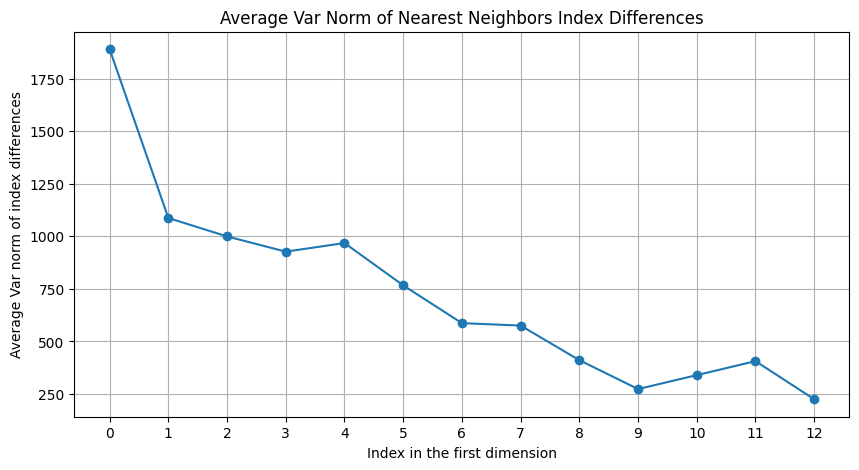

In [308]:
import torch
import matplotlib.pyplot as plt

# Generate a random tensor of shape (13, 100, 768)
# tensor = torch.concat([token_embeddings, outputs_hiddens.detach()], axis=0)
tensor = outputs_hiddens.detach()

# Placeholder for average norms for each first index
average_norms = []

# Iterate through each group in the first dimension
for i in range(tensor.shape[0]):
    data_group = tensor[i]  # Shape (100, 768)
    
    # Compute pairwise distances between vectors in the group
    dist_matrix = torch.cdist(data_group, data_group, p=2)
    
    # We set the diagonal to a very high value to avoid selecting the point itself as its neighbor
    dist_matrix.fill_diagonal_(1e5)
    
    # Get the indices of the 5 nearest neighbors for each vector
    _, indices = torch.topk(dist_matrix, k=5, largest=False)
    
    # Calculate the difference in the 2nd-dimensional indices of the neighbors
    indices_diff = indices - torch.arange(tensor.shape[1])[:, None]
    
    # Compute the L2 norm of the differences
    norms = torch.var(indices_diff.float(), dim=1)
    
    # Take the average of the norms and store
    average_norms.append(norms.mean().item())

# Plotting the average norms
plt.figure(figsize=(10, 5))
plt.plot(range(0, num_layers), average_norms, marker='o', linestyle='-')
plt.xlabel('Index in the first dimension')
plt.ylabel('Average Var norm of index differences')
plt.title('Average Var Norm of Nearest Neighbors Index Differences')
plt.xticks(range(0, num_layers))  # Adjust x-ticks to match the number of first indices
plt.grid(True)
plt.show()


In [241]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Assume data is your numpy array of shape [100, 768]
tensor = torch.concat([token_embeddings, outputs_hiddens.detach()], axis=0)
mean_norms = []
for i in tqdm(range(tensor.shape[0])):
    data = tensor[i].numpy() # Example data
    
    # Number of time steps and dimensions
    n_time, n_dims = data.shape
    
    # Initialize a matrix to hold the second derivatives
    second_derivatives = np.zeros((n_time, n_dims))
    
    # Compute second derivatives using central difference method
    # Avoid the first and last points which cannot be computed with this method
    second_derivatives[1:-1] = (data[2:] - 2 * data[1:-1] + data[:-2]) / 1**2
    
    # Calculate the norm of the second derivative vector at each time point
    norms = np.linalg.norm(second_derivatives, axis=1)
    mean_norm = norms.mean()
    mean_norms.append(mean_norm)
    
# # Plotting the norms
# plt.figure(figsize=(10, 5))
# plt.plot(mean_norms, marker='o', linestyle='-')
# plt.xlabel('Layer')
# plt.ylabel('Mean Norm')
# plt.title(f'Norm of Second Derivative Across Time for Layer {i}')
# plt.grid(True)
# plt.show()


100%|██████████| 14/14 [00:00<00:00, 2507.27it/s]


In [242]:
mean_norms

[1.6476306802525644,
 1.6476306802525644,
 18.40261680221245,
 21.648496903131246,
 22.557451100676893,
 27.520694034294014,
 26.855713058097994,
 29.71148427725447,
 30.494074158002253,
 32.42489641759515,
 41.690550627979206,
 40.06771657708555,
 36.83596190305574,
 58.43650847615322]

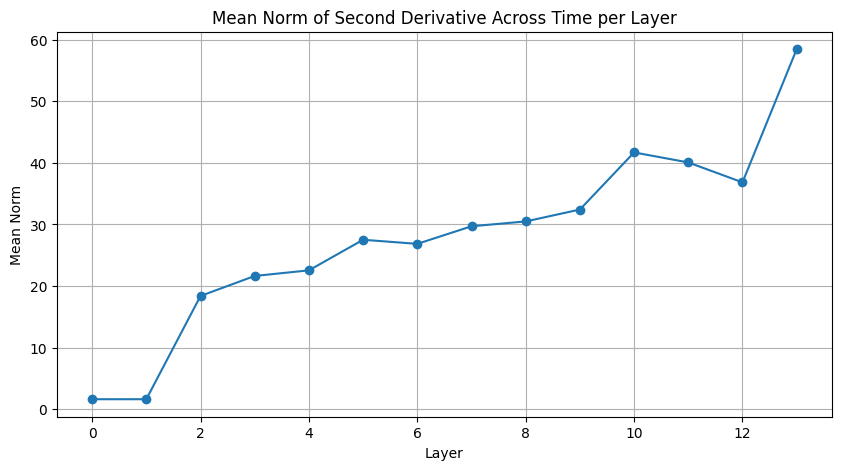

In [243]:
# Plotting the norms
plt.figure(figsize=(10, 5))
plt.plot(mean_norms, marker='o', linestyle='-')
plt.xlabel('Layer')
plt.ylabel('Mean Norm')
plt.title(f'Mean Norm of Second Derivative Across Time per Layer')
plt.grid(True)
plt.show()